In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import plotly.express as px
from sklearn.decomposition import TruncatedSVD


pd.options.display.max_rows = 120
pd.options.display.max_columns = 120

In [3]:
def plotPCA(X, y):
    svd = TruncatedSVD(n_components=2)
    X_reduced = svd.fit_transform(X)
    fig = px.scatter(
        X_reduced, x=0, y=1, color=y
    )
    fig.show()

### **GENERAL ANALYSIS & PREPROCESSING**

#### Checking spam percentage

In [7]:
data_df = pd.read_csv('spam.csv')

data_df['Message'].isna().sum()
data_df["Category"] = data_df["Category"].replace(["spam", "ham"], [1,0])
print(f'Spam percent is {data_df["Category"].sum() / len(data_df["Category"]) * 100} %')
data_df.head(5)

Spam percent is 13.406317300789663 %


,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Analysis of messages length

In [8]:
data_df['length'] = data_df['Message'].apply(len)

Text(0.5, 0, 'Message Length')

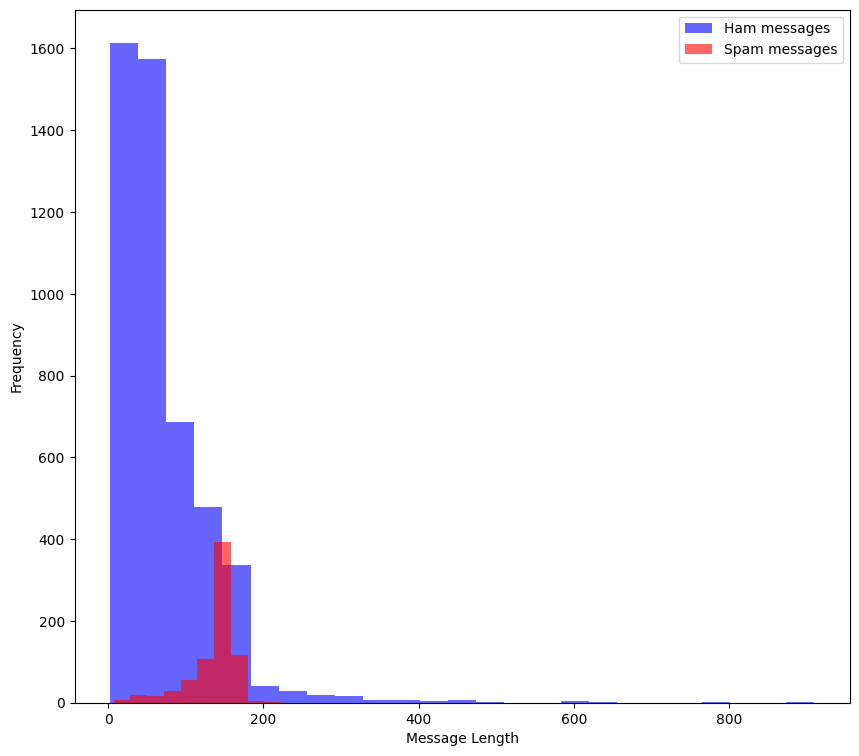

In [159]:
plt.figure(figsize=(10,9))
data_df[data_df['Category'] == 0]["length"].plot(bins=25, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
data_df[data_df['Category'] == 1]["length"].plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")


#### Removing _stop - words_

In [160]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def discard_irrelevant_chars(str : str, irr_words : list = []):
    stopwords_list = stopwords.words('english') + ['u', 'ur', 'th', '4', '2', 'im', 'dont', 'ure', 'ü'] + irr_words
    without_punct = [char for char in str if char not in string.punctuation]
    without_punct = ''.join(without_punct)
    return " ".join([word.lower() for word in without_punct.split() if word.lower() not in stopwords_list])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Murav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
data_df['clean_msg'] = data_df['Message'].apply(lambda x : discard_irrelevant_chars(x))
data_df

,Category,Message,length,clean_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,160,2nd time tried contact £750 pound prize claim ...
5568,0,Will ü b going to esplanade fr home?,36,b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity mood soany suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like id interested buying s...


#### Checking most usable words

[('get', 303), ('ltgt', 276), ('ok', 273), ('go', 250), ('ill', 238)]


<BarContainer object of 5 artists>

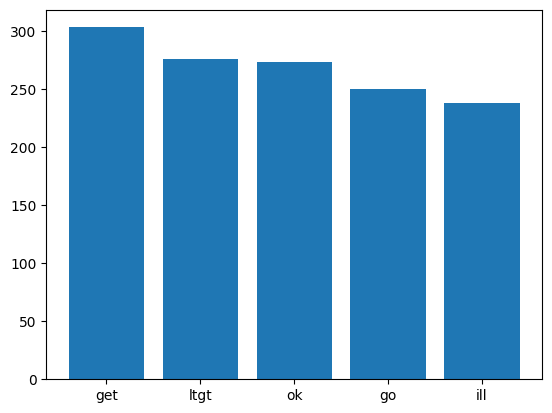

In [162]:
from collections import Counter

words = data_df[data_df.Category == 0].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(5))
plt.bar([t[0] for t in ham_words.most_common(5)],[t[1] for t in ham_words.most_common(5)] )

[('call', 344), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120)]


<BarContainer object of 5 artists>

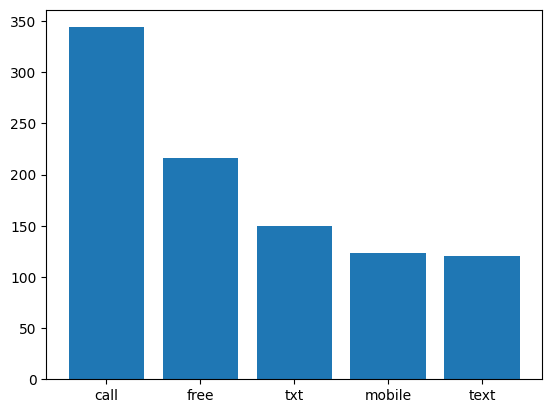

In [163]:
words = data_df[data_df.Category == 1].clean_msg.apply(lambda x: [word.lower() for word in x.split()])

spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(5))
pop_word_list = []
word_count = []
plt.bar([t[0] for t in spam_words.most_common(5)],[t[1] for t in spam_words.most_common(5)] )

#### Creating dataset with tokenized message

In [164]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tokenized = pd.DataFrame.copy(data_df)
tokenized['tokenized_text'] = data_df["clean_msg"].apply(tokenizer.tokenize)
tokenized = tokenized.drop(columns=['clean_msg', "Message"])
tokenized.head()

,Category,length,tokenized_text
0,0,111,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,"[ok, lar, joking, wif, oni]"
2,1,155,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,"[dun, say, early, hor, c, already, say]"
4,0,61,"[nah, think, goes, usf, lives, around, though]"


In [165]:
import gensim
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [167]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokenized_text'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [168]:
tokenized_category = tokenized.Category
tokenized = tokenized.drop(columns=['length', "Category"])
embeddings = get_word2vec_embeddings(word2vec, tokenized)


X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, tokenized_category,
                                                                                        test_size=0.2, random_state=856)

In [169]:
fig = plt.figure(figsize=(16, 16))          
plotPCA(X_train_word2vec, y_train_word2vec)

<Figure size 1600x1600 with 0 Axes>

#### Creating dataset Document Term-Matrix and Term Frequency-Inverse Document Frequency

In [170]:
X = data_df.drop(columns=['Message', "Category"])
y = data_df["Category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=543, test_size=0.2)
X.head()

,length,clean_msg
0,111,go jurong point crazy available bugis n great ...
1,29,ok lar joking wif oni
2,155,free entry wkly comp win fa cup final tkts 21s...
3,49,dun say early hor c already say
4,61,nah think goes usf lives around though


CountVectorizer возвращает разреженную матрицу, где каждый столбец - высказывание, каждая строчка - слово, значение ячейки - количество использований слова в данном высказывании.
Минус: игнорируется порядок слов

In [171]:
from sklearn.feature_extraction.text  import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train["clean_msg"])

X_train_dtm = vect.transform(X_train["clean_msg"])

print(type(X_train_dtm), X_train_dtm.shape, len(y_train))

X_test_dtm = vect.transform(X_test["clean_msg"])
print(type(X_test_dtm), X_test_dtm.shape, len(y_test))

<class 'scipy.sparse._csr.csr_matrix'> (4457, 8312) 4457
<class 'scipy.sparse._csr.csr_matrix'> (1115, 8312) 1115


$$TF(t,d)= \frac {Общее количество терминов в документе d} {Количество вхождений термина t в документ d}$$
​
$$IDF(t) = \log (\frac {Общее количество документов в коллекции} {количество документов содержащих термин + 1}) + 1$$
$$TFIDF = IDF * TF$$

In [172]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_TFIDF = tfidf_transformer.transform(X_train_dtm)

tfidf_transformer.fit(X_test_dtm)
X_test_TFIDF = tfidf_transformer.transform(X_test_dtm)

print(type(X_train_TFIDF), X_train_TFIDF.shape, len(y_train))
print(type(X_test_TFIDF), X_test_TFIDF.shape, len(y_test))


<class 'scipy.sparse._csr.csr_matrix'> (4457, 8312) 4457
<class 'scipy.sparse._csr.csr_matrix'> (1115, 8312) 1115


In [173]:
import plotly.express as px
from sklearn.decomposition import TruncatedSVD

plotPCA(X_train_dtm, y_train)
plotPCA(X_train_TFIDF, y_train)

### Seeking best hyperparameters

In [174]:
def get_F1_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    f1 = metrics.f1_score(y_test, predict)
    return f1 , predict

def get_pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    return predict

In [176]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

BEST_PRED_CB_DTM = []
BEST_PRED_CB_TFIDF = []
BEST_PRED_CB_W2V = []

for i in range(3):
    match i:
        case 0:
            model = CatBoostClassifier(use_best_model=True, random_seed=42, logging_level='Silent')
            model.fit(X_train_dtm, y_train, eval_set=(X_test_dtm, y_test))
            y_pred = model.predict(X_test_dtm)
            best_iter = model.get_best_iteration()
            BEST_PRED_CB_DTM = y_pred
            print(f'Best model iteration for DTM: {best_iter}')
        case 1:
            model = CatBoostClassifier(use_best_model=True, random_seed=42, logging_level='Silent')
            model.fit(X_train_TFIDF, y_train, eval_set=(X_test_TFIDF, y_test))
            y_pred = model.predict(X_test_TFIDF)
            best_iter = model.get_best_iteration()
            BEST_PRED_CB_TFIDF = y_pred
            print(f'Best model iteration for TFIDF: {best_iter}')
        case 2:
            model = CatBoostClassifier(use_best_model=True, random_seed=42, logging_level='Silent')
            model.fit(X_train_word2vec, y_train_word2vec, eval_set=(X_test_word2vec, y_test_word2vec))
            y_pred = model.predict(X_test_word2vec)
            best_iter = model.get_best_iteration()
            BEST_PRED_CB_W2V = y_pred
            print(f'Best model iteration for TFIDF: {best_iter}')



Best model iteration for DTM: 999
Best model iteration for TFIDF: 995
Best model iteration for TFIDF: 310


In [178]:
f1_result_score = []

In [268]:
# !!! Cell will be computing 28 hours !!! 
for n_trees in range(10, 221, 30):
    for depth in range (5, 106, 25):
        f1_score_dtm_GBC, predict_dtm_GBC = get_F1_score(GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth), X_train_dtm, y_train, X_test_dtm, y_test)
        f1_score_TFIDF_GBC, predict_TFIDF_GBC = get_F1_score(GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth), X_train_TFIDF, y_train, X_test_TFIDF, y_test)
        f1_score_W2V_GBC, predict_W2V_GBC = get_F1_score(GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth), X_train_word2vec, y_train, X_test_word2vec, y_test)
        
        f1_score_dtm_RF, predict_dtm_RF = get_F1_score(RandomForestClassifier(n_estimators=n_trees, max_depth=depth), X_train_dtm, y_train, X_test_dtm, y_test)
        f1_score_TFIDF_RF, predict_TFIDF_RF = get_F1_score(RandomForestClassifier(n_estimators=n_trees, max_depth=depth), X_train_TFIDF, y_train, X_test_TFIDF, y_test)
        f1_score_W2V_RF, predict_W2V_RF = get_F1_score(RandomForestClassifier(n_estimators=n_trees, max_depth=depth), X_train_word2vec, y_train, X_test_word2vec, y_test)
        
        f1_result_score.append([n_trees, depth, f1_score_dtm_GBC, f1_score_TFIDF_GBC, f1_score_W2V_GBC, f1_score_dtm_RF, f1_score_TFIDF_RF, f1_score_W2V_RF])        
        print(depth,"/", 106, "  ", n_trees, "/", 211)


5 / 106    10 / 211
30 / 106    10 / 211
55 / 106    10 / 211
80 / 106    10 / 211
105 / 106    10 / 211
5 / 106    40 / 211
30 / 106    40 / 211
55 / 106    40 / 211
80 / 106    40 / 211
105 / 106    40 / 211
5 / 106    70 / 211
30 / 106    70 / 211
55 / 106    70 / 211
80 / 106    70 / 211
105 / 106    70 / 211
5 / 106    100 / 211
30 / 106    100 / 211
55 / 106    100 / 211
80 / 106    100 / 211
105 / 106    100 / 211
5 / 106    130 / 211
30 / 106    130 / 211
55 / 106    130 / 211
80 / 106    130 / 211
105 / 106    130 / 211
5 / 106    160 / 211
30 / 106    160 / 211
55 / 106    160 / 211
80 / 106    160 / 211
105 / 106    160 / 211
5 / 106    190 / 211
30 / 106    190 / 211
55 / 106    190 / 211
80 / 106    190 / 211
105 / 106    190 / 211
5 / 106    220 / 211
30 / 106    220 / 211
55 / 106    220 / 211
80 / 106    220 / 211
105 / 106    220 / 211


In [275]:
# F1_RESULTS = np.array(f1_result_score)
# np.savetxt("correct_res.csv", F1_RESULTS, delimiter=",")

In [179]:
F1_RESULTS = pd.read_csv('correct_res.csv')
F1_RESULTS.columns = ["n_trees", "depth", "f1_score_dtm_GBC", "f1_score_TFIDF_GBC", "f1_score_W2V_GBC", "f1_score_dtm_RF", "f1_score_TFIDF_RF", "f1_score_W2V_RF"]
print(F1_RESULTS)

    n_trees  depth  f1_score_dtm_GBC  f1_score_TFIDF_GBC  f1_score_W2V_GBC  \
0      10.0   10.0          0.827068            0.680000          0.000000   
1      10.0   15.0          0.844444            0.695652          0.000000   
2      10.0   20.0          0.864469            0.715953          0.000000   
3      10.0   25.0          0.865455            0.728682          0.022989   
4      10.0   30.0          0.856089            0.728682          0.000000   
5      10.0   35.0          0.860215            0.733591          0.023256   
6      10.0   40.0          0.856115            0.737643          0.023121   
7      10.0   45.0          0.869258            0.730038          0.011561   
8      10.0   50.0          0.861210            0.745247          0.022222   
9      10.0   55.0          0.880282            0.750000          0.011050   
10     10.0   60.0          0.873239            0.736842          0.056497   
11     10.0   65.0          0.875000            0.744361        

In [180]:
def show_best_hyperparameters(X,Y,Z, X_name, Y_name, title, colormap = "winter"):
    plt.scatter(X, Y, c=Z, cmap=colormap, marker='o', edgecolor='k')
    cbar = plt.colorbar()
    plt.xlabel(X_name)
    plt.ylabel(Y_name)
    plt.title(title)
    print()

def return_best_predict_settings(f1_results, column):
    best_res = f1_results.sort_values(by=[column], ascending = False).reset_index(drop=True).iloc[[0]]
    return best_res
    

In [181]:
best_results = pd.DataFrame(columns=F1_RESULTS.columns)

for current_type in  F1_RESULTS.columns[2:]:
    best_res = return_best_predict_settings(F1_RESULTS, current_type)
    best_results = pd.concat([best_results, best_res], ignore_index=True, axis=0)

print(f'f1 score CatBoost for DTM data {metrics.f1_score(y_test, BEST_PRED_CB_DTM)}')
print(f'f1 score CatBoost for TFIDF data {metrics.f1_score(y_test, BEST_PRED_CB_TFIDF)}')
print(f'f1 score CatBoost for W2V data {metrics.f1_score(y_test, BEST_PRED_CB_W2V)}')

best_results

f1 score CatBoost for DTM data 0.9310344827586208
f1 score CatBoost for TFIDF data 0.9204152249134949
f1 score CatBoost for W2V data 0.10344827586206896


C:\Users\Murav\AppData\Local\Temp\ipykernel_2288\522686156.py:5: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,n_trees,depth,f1_score_dtm_GBC,f1_score_TFIDF_GBC,f1_score_W2V_GBC,f1_score_dtm_RF,f1_score_TFIDF_RF,f1_score_W2V_RF
0,220.0,5.0,0.916667,0.863309,0.000000,0.000000,0.000000,0.000000
1,220.0,5.0,0.916667,0.863309,0.000000,0.000000,0.000000,0.000000
2,130.0,105.0,0.890411,0.739927,0.064865,0.900000,0.907801,0.000000
3,20.0,95.0,0.875000,0.750000,0.033333,0.919298,0.912281,0.000000
4,20.0,95.0,0.875000,0.750000,0.033333,0.919298,0.912281,0.000000
5,10.0,20.0,0.864469,0.715953,0.000000,0.747967,0.643172,0.054645


In [182]:
diagonal_values = pd.Series(np.diag(best_results[best_results.columns[2:]]), index=best_results.index)
best_results[best_results.columns[2:]] = pd.DataFrame(np.diag(diagonal_values)).replace(0, np.nan)
best_results

,n_trees,depth,f1_score_dtm_GBC,f1_score_TFIDF_GBC,f1_score_W2V_GBC,f1_score_dtm_RF,f1_score_TFIDF_RF,f1_score_W2V_RF
0,220.0,5.0,0.916667,NaN,NaN,NaN,NaN,NaN
1,220.0,5.0,NaN,0.863309,NaN,NaN,NaN,NaN
2,130.0,105.0,NaN,NaN,0.064865,NaN,NaN,NaN
3,20.0,95.0,NaN,NaN,NaN,0.919298,NaN,NaN
4,20.0,95.0,NaN,NaN,NaN,NaN,0.912281,NaN
5,10.0,20.0,NaN,NaN,NaN,NaN,NaN,0.054645


In [183]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train_dtm, y_train)
predict_dtm = LR.predict(X_test_dtm)
print(f'Logistic accuracy for dtm {metrics.accuracy_score(y_test, predict_dtm)}')
print(metrics.confusion_matrix(y_test, predict_dtm)) 
LR = LogisticRegression()
LR.fit(X_train_TFIDF, y_train)
predict_TFIDF = LR.predict(X_test_TFIDF)
print(f'Logistic accuracy for TFIDF {metrics.accuracy_score(y_test, predict_TFIDF)}')
print(metrics.confusion_matrix(y_test, predict_TFIDF))
LR = LogisticRegression()
LR.fit(X_train_word2vec, y_train)
predict_w2v = LR.predict(X_test_word2vec)
print(f'Logistic accuracy for W2V {metrics.accuracy_score(y_test, predict_w2v)}')
print(metrics.confusion_matrix(y_test, predict_w2v)) 

Logistic accuracy for dtm 0.9829596412556054
[[961   0]
 [ 19 135]]
Logistic accuracy for TFIDF 0.9659192825112107
[[959   2]
 [ 36 118]]
Logistic accuracy for W2V 0.8618834080717489
[[961   0]
 [154   0]]


### Trying to improve accuracy

Точность SC для dtm 0.9856502242152466


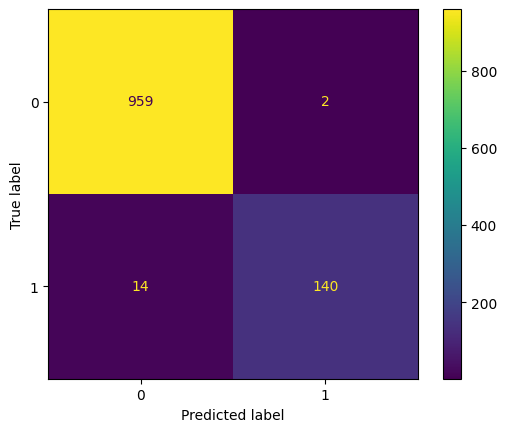

Точность SC для TFIDF 0.9811659192825112


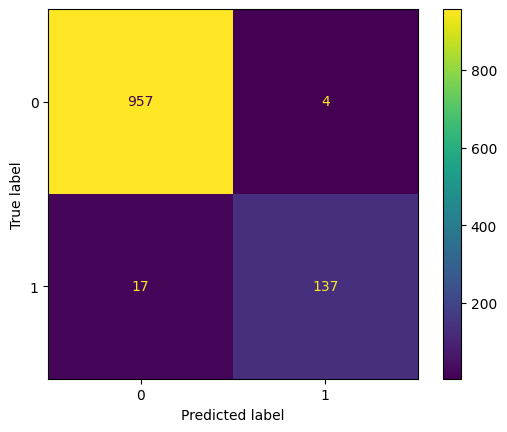

Точность SC для W2V 0.8663677130044843


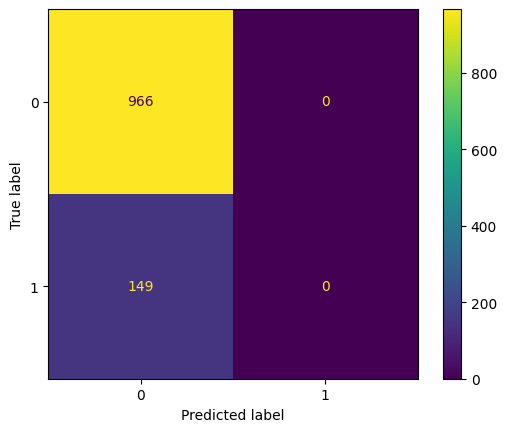

In [184]:
from sklearn.ensemble import StackingClassifier

estimators = [('RF', RandomForestClassifier(n_estimators=20, max_depth=90)),
              ('GB', GradientBoostingClassifier(n_estimators=220, max_depth=5)),
              ('CB', CatBoostClassifier(iterations=999, logging_level='Silent')),
              ('Logistic', LogisticRegression())
              ]
SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=4)

SC.fit(X_train_dtm, y_train)
y_pred = SC.predict(X_test_dtm)
print(f'Точность SC для dtm {metrics.accuracy_score(y_test, y_pred)}')
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

SC.fit(X_train_TFIDF, y_train)
y_pred = SC.predict(X_test_TFIDF)
print(f'Точность SC для TFIDF {metrics.accuracy_score(y_test, y_pred)}')
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

SC.fit(X_train_word2vec, y_train)
y_pred = SC.predict(X_test_word2vec)
print(f'Точность SC для W2V {metrics.accuracy_score(y_test_word2vec, y_pred)}')
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_word2vec, y_pred))
disp.plot()
plt.show()
